In [1]:
pip install pip --upgrade

Requirement already up-to-date: pip in /Users/avik/anaconda3/lib/python3.7/site-packages (19.3.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U statsmodels

Requirement already up-to-date: statsmodels in /Users/avik/anaconda3/lib/python3.7/site-packages (0.10.2)
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /Users/avik/anaconda3/lib/python3.7/site-packages (0.22)
Note: you may need to restart the kernel to use updated packages.


In [7]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

df = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


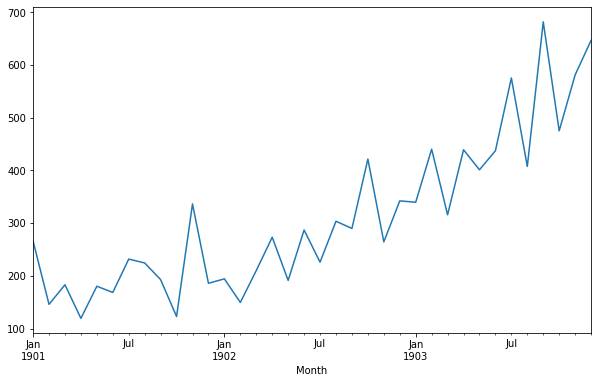

In [21]:
print(df.head())
pyplot.figure(figsize=(10,6))
df.plot()
pyplot.show()

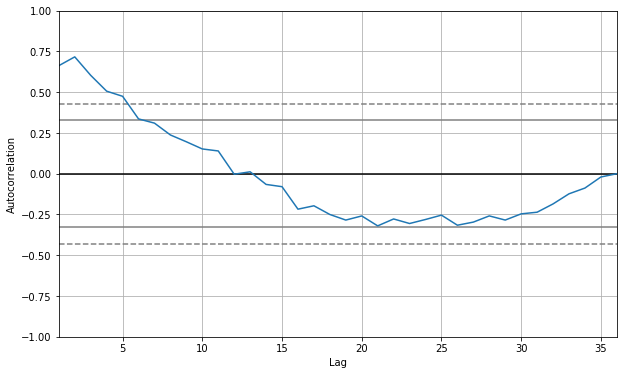

In [22]:
from pandas.plotting import autocorrelation_plot

pyplot.figure(figsize=(10,6))
autocorrelation_plot(df)
pyplot.show()

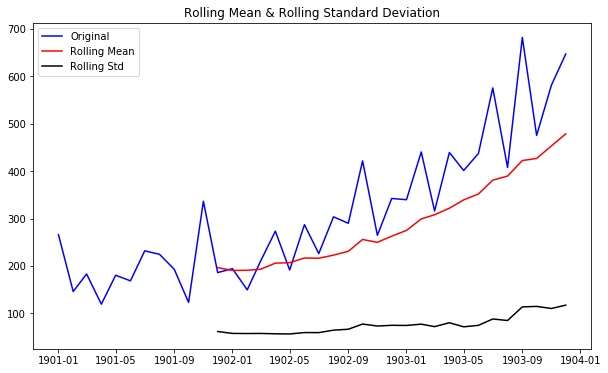

In [10]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
pyplot.figure(figsize=(10,6))
pyplot.plot(df, color = 'blue', label = 'Original')
pyplot.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
pyplot.plot(rolling_std, color = 'black', label = 'Rolling Std')
pyplot.legend(loc = 'best')
pyplot.title('Rolling Mean & Rolling Standard Deviation')
pyplot.show()

In [11]:
result = adfuller(df)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 3.0601420836411806
p-value: 1.0
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


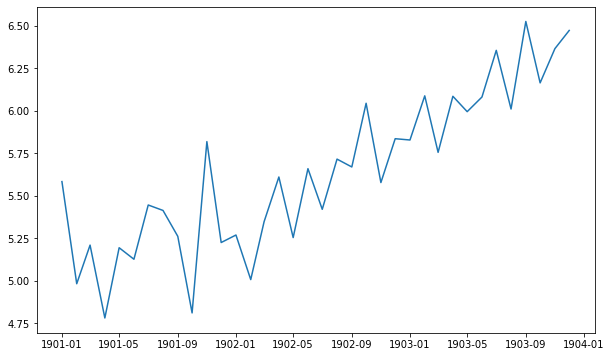

In [12]:
# Log values
df_log = np.log(df)
pyplot.figure(figsize=(10,6))
pyplot.plot(df_log)

In [13]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    pyplot.figure(figsize=(10,6))
    original = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolling_mean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolling_std, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

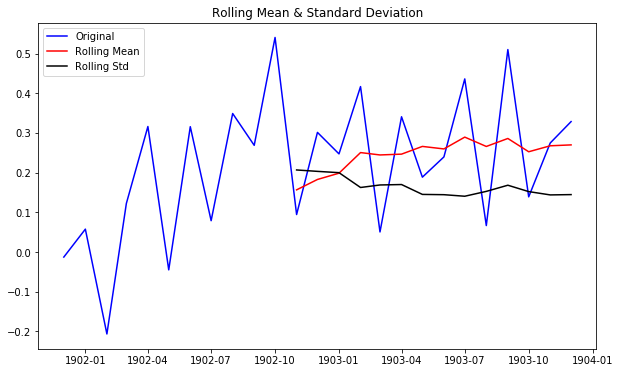

ADF Statistic: -2.8666384708515986
p-value: 0.04936730550579396
Critical Values:
	1%: -3.9240193847656246
	5%: -3.0684982031250003
	10%: -2.67389265625


In [14]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

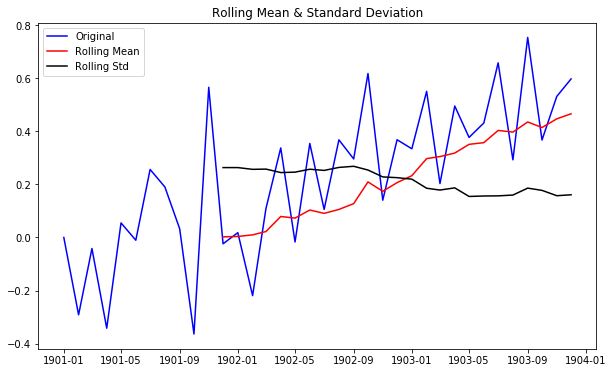

ADF Statistic: -0.9453530717367268
p-value: 0.7726705008438277
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


In [15]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

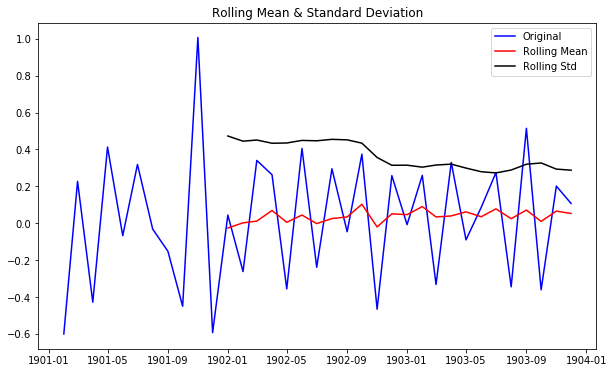

ADF Statistic: -2.1682021458141496
p-value: 0.2179879382560318
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


In [16]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

/Users/avik/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/avik/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


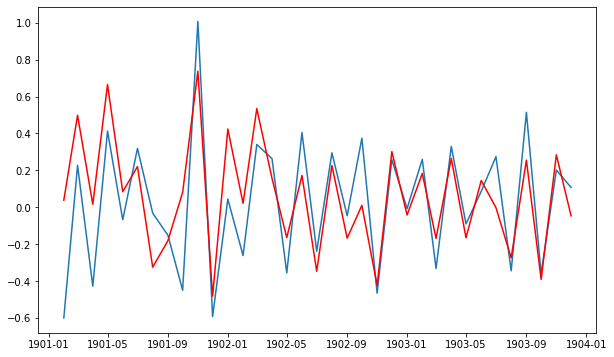

In [17]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(5,1,0))
results = model.fit(disp=0)
pyplot.figure(figsize=(10,6))
pyplot.plot(df_log_shift)
pyplot.plot(results.fittedvalues, color='red')

In [18]:
for x in range(len(results.fittedvalues)):
    print("Expected: " + str(df[x]) + "\t\tPredicted: " + str(df[x] + results.fittedvalues[x]) + "\t\tDifferernce: " + str(results.fittedvalues[x]))

error = mean_squared_error(df_log_shift, results.fittedvalues)
print('Test MSE: %.10f' % error)

Expected: 266.0		Predicted: 266.03809667110045		Differernce: 0.038096671100423585
Expected: 145.9		Predicted: 146.39849029766776		Differernce: 0.49849029766775393
Expected: 183.1		Predicted: 183.11603910951558		Differernce: 0.016039109515583405
Expected: 119.3		Predicted: 119.9652668499813		Differernce: 0.6652668499813121
Expected: 180.3		Predicted: 180.3841494263282		Differernce: 0.08414942632820754
Expected: 168.5		Predicted: 168.7205839585781		Differernce: 0.22058395857808197
Expected: 231.8		Predicted: 231.47497478673318		Differernce: -0.3250252132668387
Expected: 224.5		Predicted: 224.31889527992544		Differernce: -0.1811047200745708
Expected: 192.8		Predicted: 192.88085207223432		Differernce: 0.08085207223430746
Expected: 122.9		Predicted: 123.63731138880745		Differernce: 0.7373113888074428
Expected: 336.5		Predicted: 336.01829440746053		Differernce: -0.48170559253948586
Expected: 185.9		Predicted: 186.32399911579574		Differernce: 0.4239991157957458
Expected: 194.3		Predicted: 194

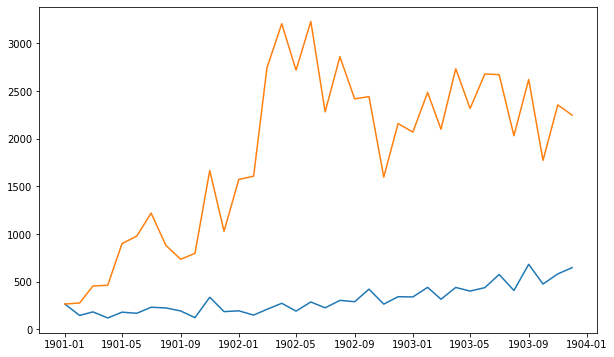

In [25]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
pyplot.figure(figsize=(10,6))
pyplot.plot(df)
pyplot.plot(predictions_ARIMA)

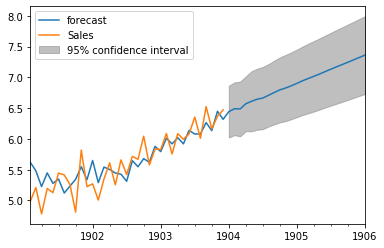

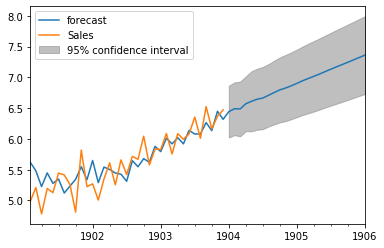

In [27]:
results.plot_predict(1,60)